In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import matplotlib.animation as animation
import csv
# matplotlib.style.use('seaborn')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from wordcloud import WordCloud

from mpl_toolkits.mplot3d import Axes3D

In [2]:
author_data=pd.read_csv("author_data.csv")
author_data.index=author_data.id
author_data=author_data[["gender","age","topic","sign","grupo_edad","Freq"]]
author_data.sample(20)

gender  age       topic         sign grupo_edad  Freq
id                                                            
1810524  female   17     Student     Aquarius          A   196
3946278  female   23   Education        Libra          B     7
4056016    male   13    Military  Sagittarius          A     4
1599382  female   24      indUnk       Gemini          B    30
2895671    male   24      indUnk        Aries          B    24
3784830  female   26      indUnk          Leo          B    11
3403340    male   15      indUnk        Virgo          A     3
3418014  female   15     Student       Gemini          A     9
698753   female   24      indUnk        Libra          B   507
4202679  female   16         Law        Virgo          A    12
3294266    male   16     Student       Gemini          A     5
3338228  female   25     Science    Capricorn          B     4
3378992  female   14        Arts       Gemini          A     9
4061147  female   37      indUnk          Leo          C     3
4159684  female   13     Student       Pisces          A     4
4042332    male   23  Technology        Virgo          B    12
244521     male   27      indUnk        Aries          B    33
3504079  female   27      indUnk       Gemini          B     8
3404705  female   17     Student       Cancer          A     6
3829920    male   23     Science       Cancer          B     8

In [3]:
words=pd.read_csv("frq_outh_complete_colnames.csv",header=None,index_col=None)

In [4]:
tfidf_data=pd.read_csv("frq_outh_complete_1.csv",header=None,index_col=None)#_2# This dataframe is already normalized to max val
tfidf_data.index=author_data.index
tfidf_data.columns=list(words[0])
tfidf_data=tfidf_data.apply(pd.to_numeric,downcast='unsigned')
print(tfidf_data.shape)
tfidf_data.sample(20)

(18981, 500)


though  school  always  ever  better  myself  let  year  another  \
id                                                                          
3981555       0       0       1     0       2       0    0     0        0   
4189164       0       0       1     1       1       0    0     1        0   
3733849       3       6       2     2       3       1    5     1        3   
3315411       3       2       0     2       3       2    4     3        6   
3865283       2       0       2     3       1       0    1     2        3   
4255769       0       0       4     1       3       0    4     0        1   
3388436       3       1       4     1       2       2    1     4        3   
3968079       0       0       0     2       0       0    2     0        0   
3823391       3       0       3     0       2       0    3     1        1   
4321351       3       0       8     4       3       8    7     2        6   
3383754       2       1       0     1       0       0    1     0        2   
3465669       1       1       2     2       1       1    0     1        4   
3702150       0       2       7     5       1       0    2     6        1   
3947725       0       0       0     0       0       0    0     0        0   
4132319       0       2       1     1       7      10    1    14        0   
3617048       0       0       0     0       0       0    0     0        0   
3868923       0       0       1     0       0       0    0     0        0   
1055228       1       0       0     1       1       0    0     0        0   
1315210       1       3       0     2       1       1    0     0        0   
3723549      48      33      44    53      31      47   36    20       44   

         many   ...    president  english  cute  longer  internet  dead  rock  \
id              ...                                                             
3981555     0   ...            0        0     0       0         0     0     0   
4189164     1   ...            0        0     0       0         0     0     0   
3733849     3   ...            0        0     0       2         1     1     0   
3315411     2   ...            1        0     1       1         1     0     0   
3865283     0   ...            0        0     0       1         0     1     1   
4255769     0   ...            0        1     2       0         0     0     0   
3388436     1   ...            0        0     0       0         0     0     0   
3968079     0   ...            0        0     0       0         0     0     0   
3823391     3   ...            0        0     0       0         0     0     1   
4321351     1   ...            0        0     0       3         0     2     0   
3383754     0   ...            0        0     0       0         0     0     0   
3465669     2   ...            0        0     0       1         3     0     1   
3702150     2   ...            0        1     0       0         1     0     1   
3947725     0   ...            0        0     0       0         0     0     0   
4132319     3   ...            0        0     0       1         0     0     0   
3617048     0   ...            0        0     0       0         0     0     0   
3868923     0   ...            0        0     0       0         0     0     0   
1055228     0   ...            0        0     0       0         0     0     0   
1315210     1   ...            0        0     1       0         0     0     0   
3723549    48   ...            7       26     9       7         1     9     2   

         special  road  forget  
id                              
3981555        0     0       0  
4189164        0     2       1  
3733849        2     0       0  
3315411        1     1       1  
3865283        0     1       1  
4255769        0     1       3  
3388436        0     1       0  
3968079        0     0       0  
3823391        0     0       0  
4321351        1     0       3  
3383754        0     0       0  
3465669        1     0       0  
3702150        0     0       1  
3947725        0     0       0  
413

# Clustering semisupervisado
Se reduce dimensionalmente una muestra, se obtienen los cluster y se proyecta estos puntos mediante KNN

In [5]:
tfidf_data_sample=tfidf_data.sample(frac=.3)
tfidf_data_sample.shape

(5694, 500)

In [6]:
print(tfidf_data.shape)
print(tfidf_data_sample.shape)

(18981, 500)
(5694, 500)


## Reducción dimensional

### PCA

In [7]:
pca=PCA()
pca.fit(tfidf_data)
pca_coords=pca.transform(tfidf_data_sample)

500

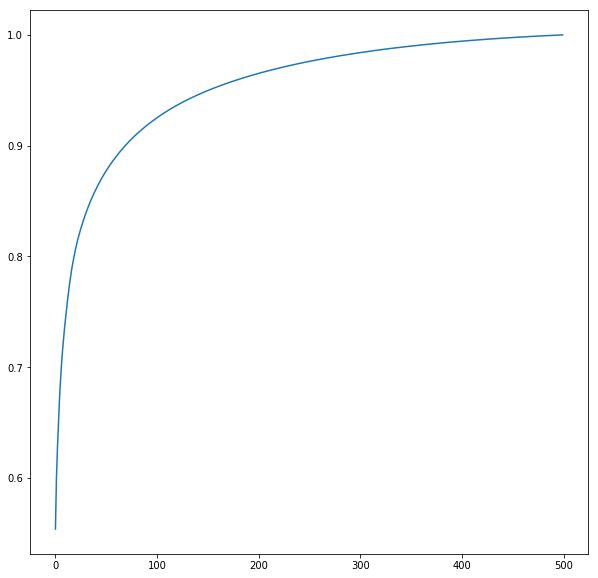

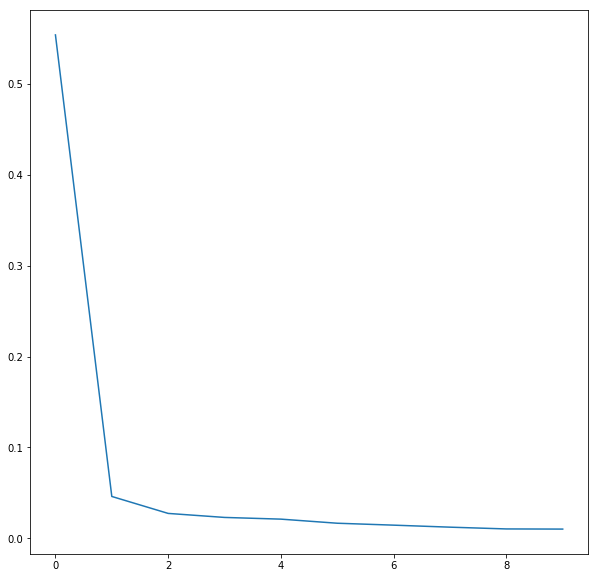

In [8]:
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_.cumsum())
len(pca.explained_variance_ratio_)

plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_[:10])
len(pca.explained_variance_ratio_)

In [9]:
comps_pca_var=pd.DataFrame({"var_comp":pca.explained_variance_ratio_,
              "cumsum":pca.explained_variance_ratio_.cumsum()})

In [10]:
comps_pca_var[comps_pca_var["cumsum"]<=.82]

cumsum  var_comp
0   0.553782  0.553782
1   0.599906  0.046124
2   0.627383  0.027477
3   0.650443  0.023060
4   0.671626  0.021183
5   0.688306  0.016680
6   0.702872  0.014566
7   0.715226  0.012354
8   0.725630  0.010404
9   0.735865  0.010234
10  0.744590  0.008726
11  0.753162  0.008572
12  0.761363  0.008201
13  0.768989  0.007626
14  0.775902  0.006913
15  0.782387  0.006485
16  0.788484  0.006097
17  0.793646  0.005162
18  0.798547  0.004902
19  0.803273  0.004725
20  0.807609  0.004336
21  0.811545  0.003936
22  0.815343  0.003798
23  0.818770  0.003427

In [11]:
auth_ward_PCA=hierarchy.linkage(pca_coords[:,:19], 'ward')#tfidf_data

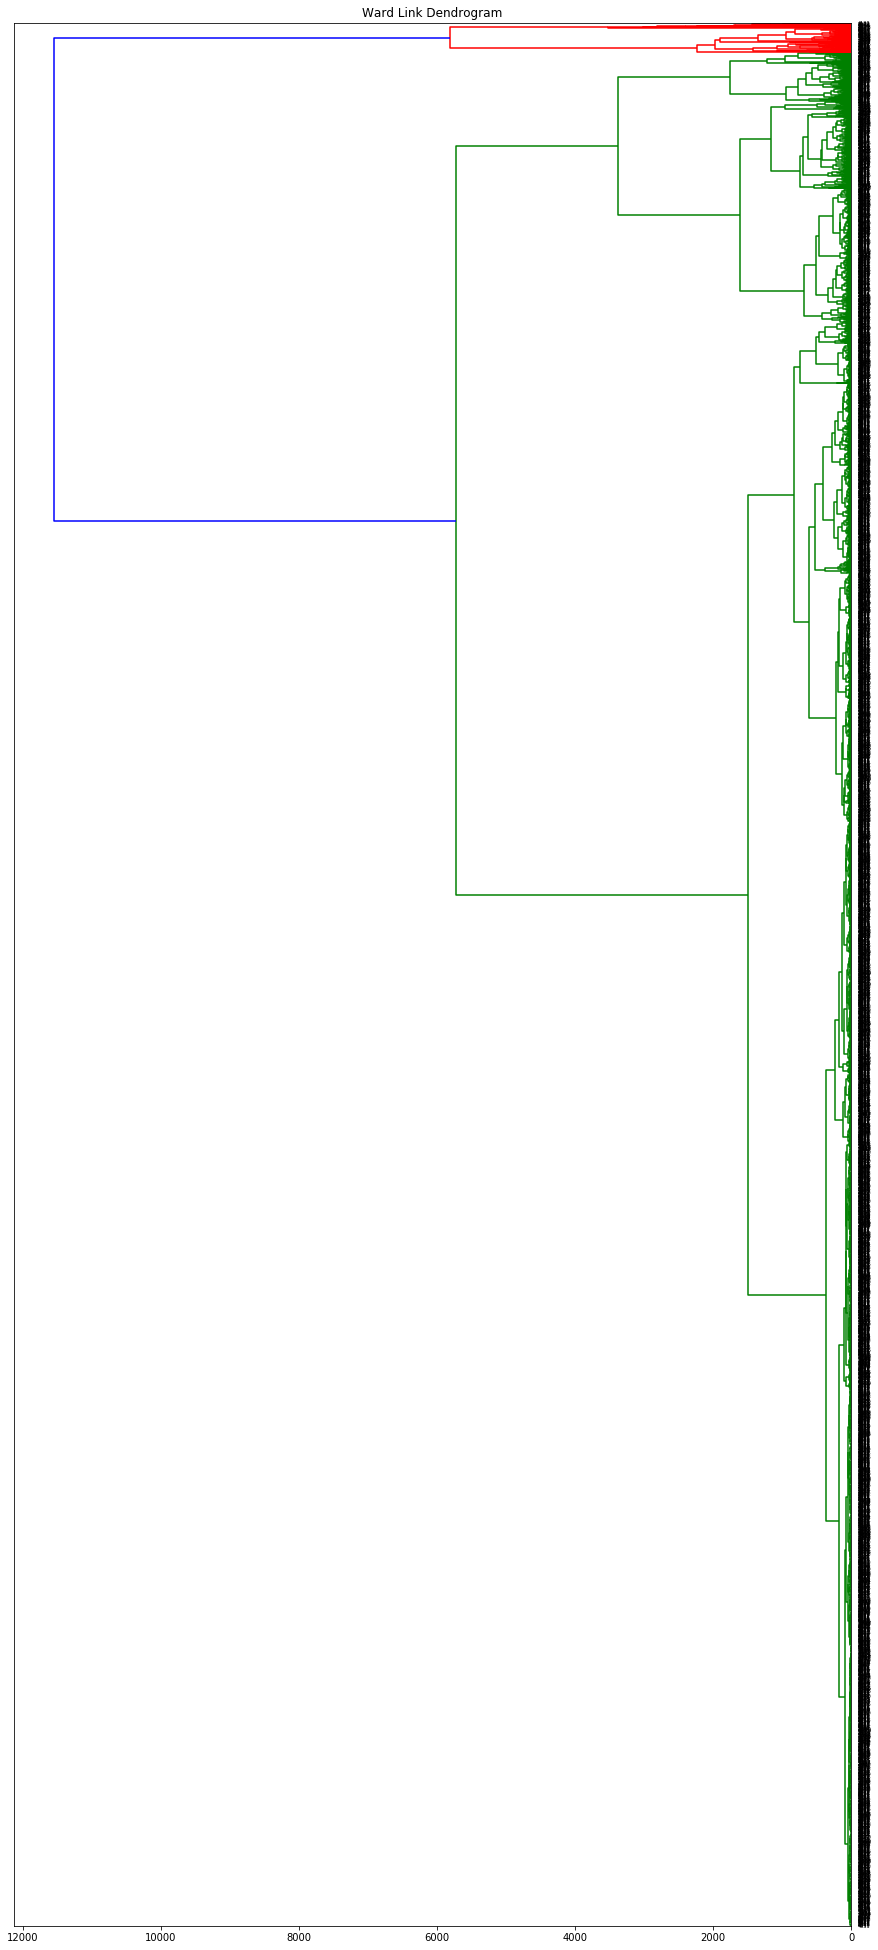

In [12]:
plt.figure(figsize=(15,35))
dn_tf_PCA = hierarchy.dendrogram(auth_ward_PCA,orientation="left")
plt.title('Ward Link Dendrogram')
plt.show()

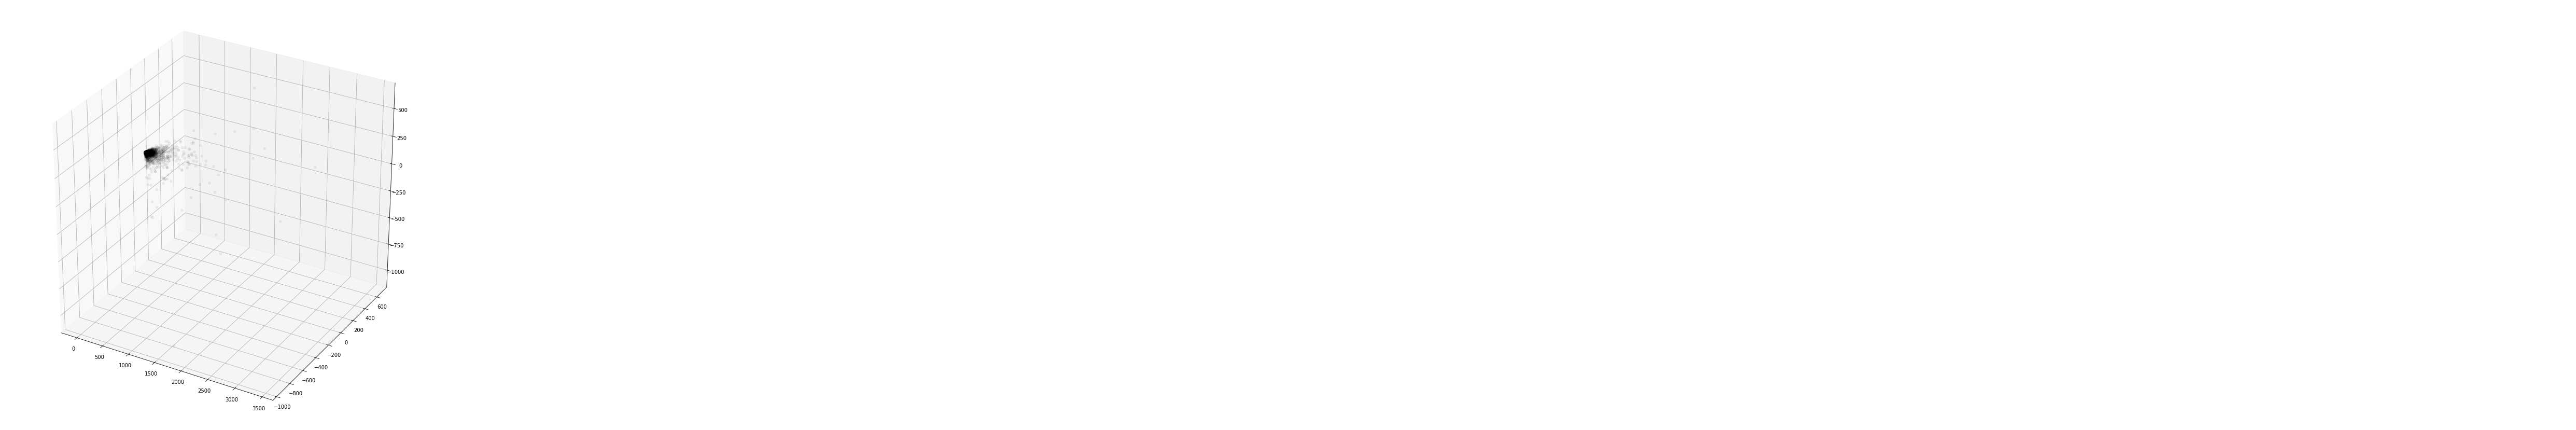

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=pca_coords[:,0],
           ys=pca_coords[:,1],
           zs=pca_coords[:,2],
           c="black", 
           alpha=.05,
           cmap=plt.cm.Set1)

### Spectral Embedding

In [14]:
# 3d Embedding for visualization
spect_emb_3=manifold.SpectralEmbedding(n_components=19, n_jobs=-1).fit_transform(tfidf_data_sample)#author_data_norm)#

In [23]:
spect_emb_3=spect_emb_3*1000

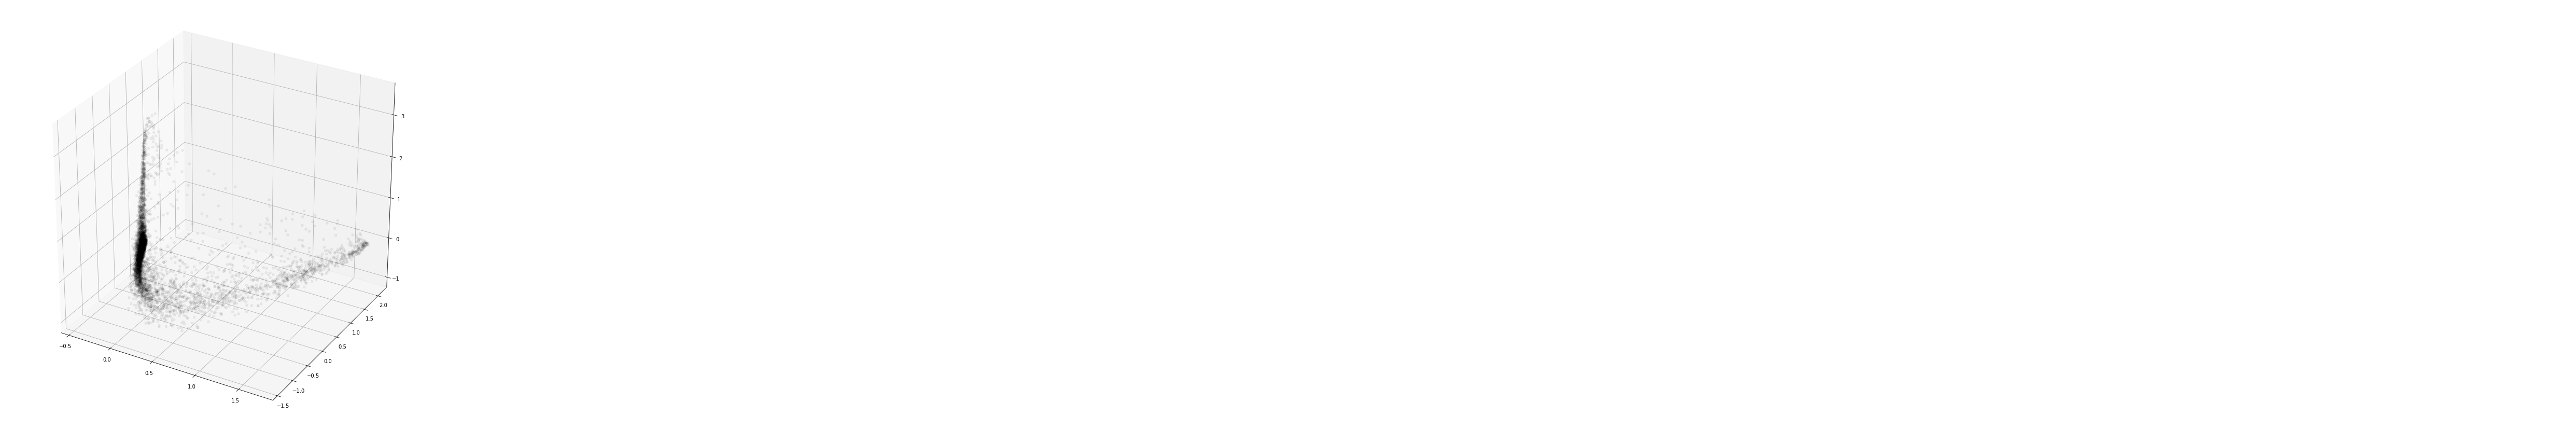

In [24]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=spect_emb_3[:,0],
           ys=spect_emb_3[:,1],
           zs=spect_emb_3[:,2],
           c="black", 
           alpha=.05,
           cmap=plt.cm.Set1)


In [16]:
auth_ward_spect=hierarchy.linkage(spect_emb_3, 'ward')#tfidf_data

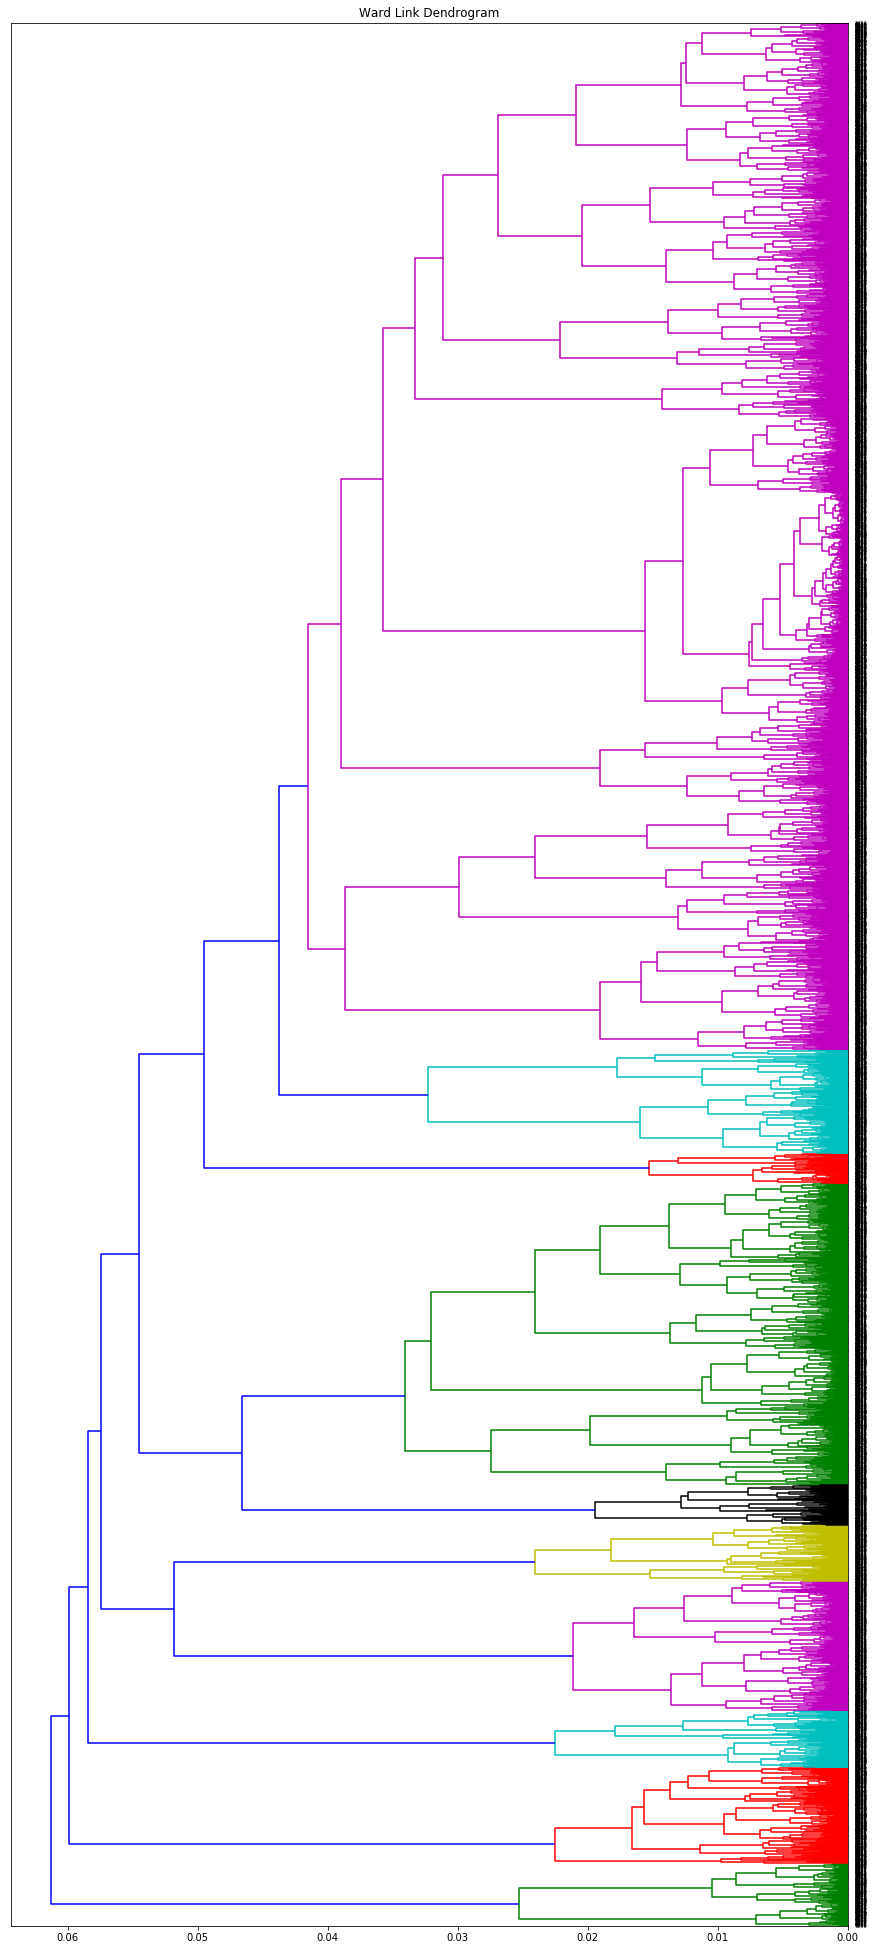

In [17]:
plt.figure(figsize=(15,35))
dn_tf_spect = hierarchy.dendrogram(auth_ward_spect,orientation="left")
plt.title('Ward Link Dendrogram')
plt.show()

#### Conclusiones:

Se define trabajar spectral embedding con 19 dimensiones (tomadas de la varianza explicada del PCA al 80%) y se grafica en las 3 primeras dimensiones del spectral embedding.

# Clustering

In [18]:
connectivity = kneighbors_graph(spect_emb_3, n_neighbors=20, include_self=False)
ward = AgglomerativeClustering(n_clusters=14, connectivity=connectivity,
                               linkage='ward').fit(spect_emb_3)
label = ward.labels_

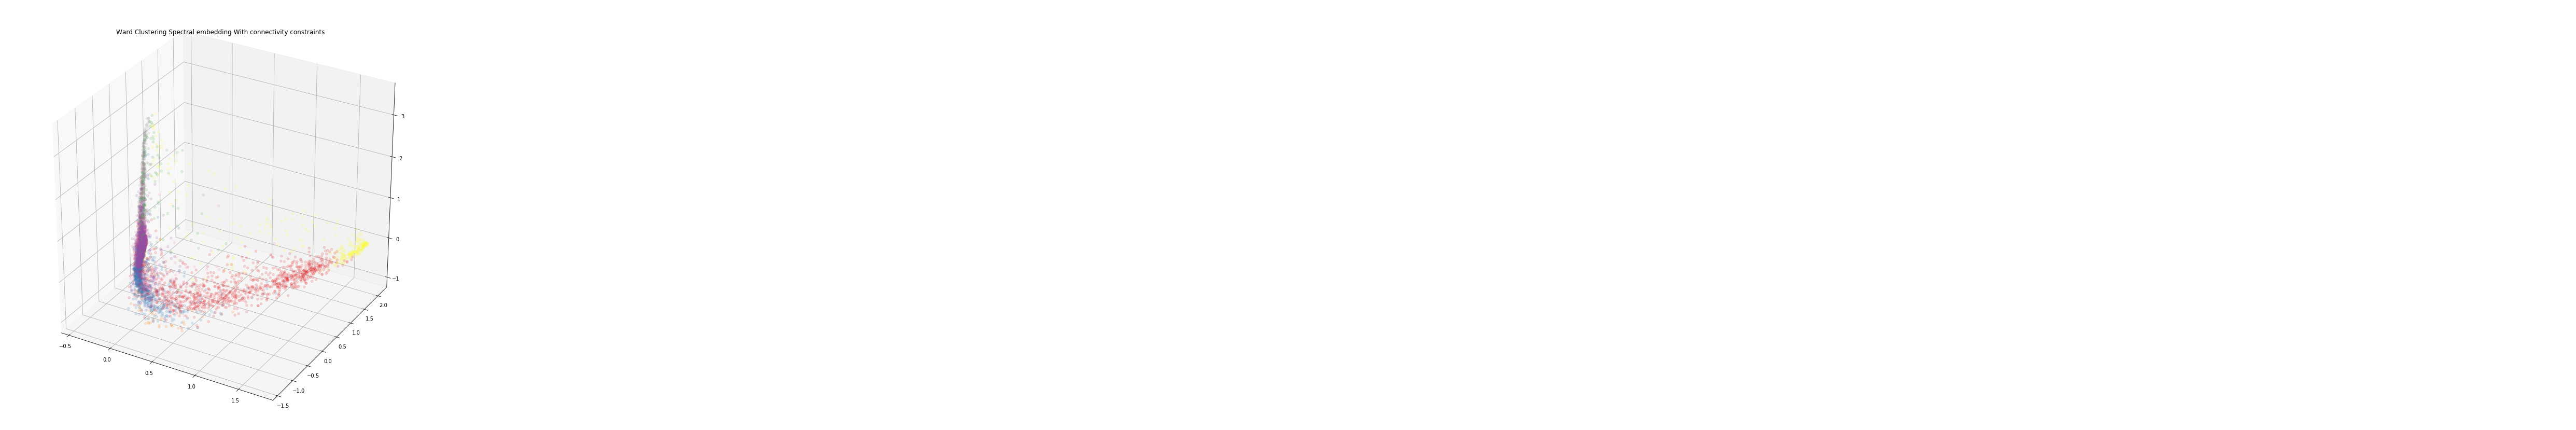

In [25]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for lb in np.unique(label):
    ax.scatter(spect_emb_3[label == lb, 0], 
               spect_emb_3[label == lb, 1], 
               spect_emb_3[label == lb, 2],
               color=plt.cm.Set1(float(lb) / np.max(label + 1)),
               s=20, edgecolor=None, alpha=.15)
plt.title('Ward Clustering Spectral embedding With connectivity constraints')
plt.show()

In [20]:
pd.crosstab(index=label, columns="count")

col_0  count
row_0       
0        911
1        340
2        855
3        171
4        115
5        420
6       1115
7         89
8        116
9        188
10       305
11       278
12       447
13       344

Text(0.5, 1.0, '2d spectral coordinates from 3d spectral hierarchical (ward) clustering')

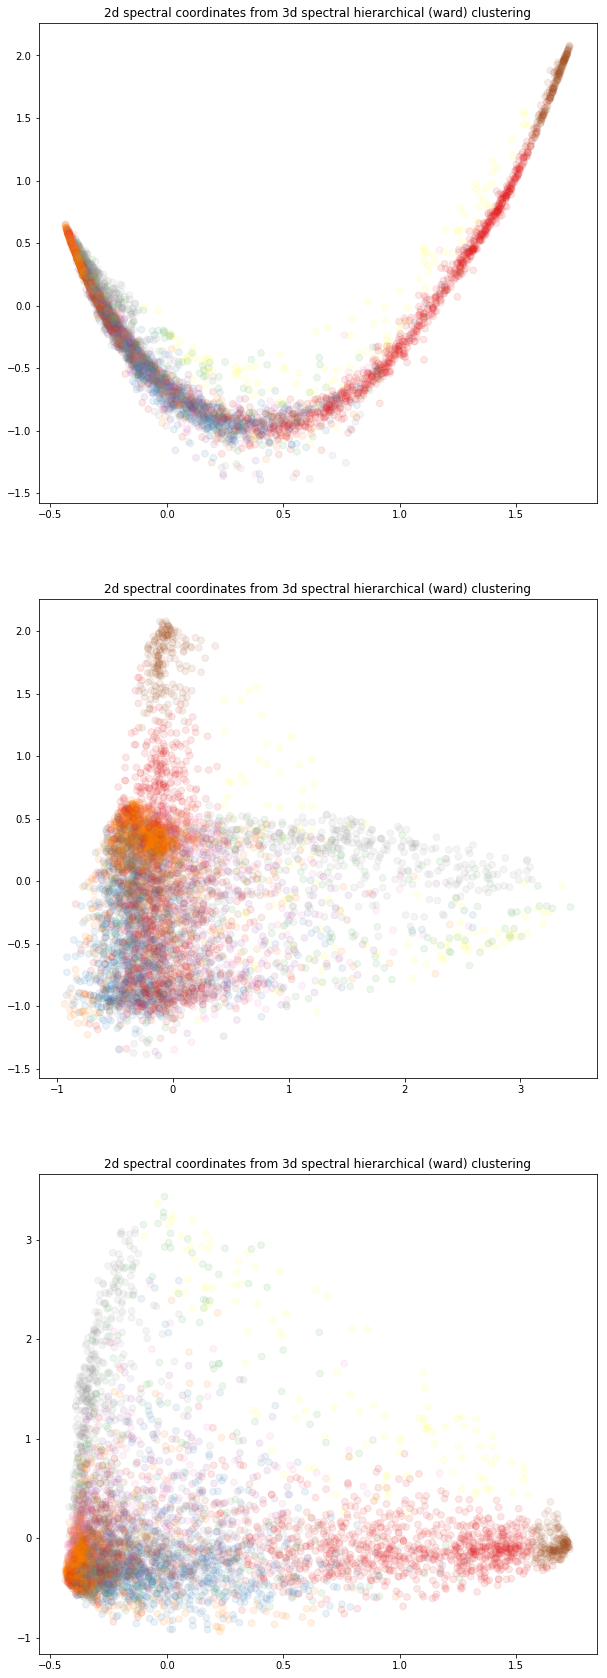

In [26]:
plt.figure(figsize=(10,30))
par_alf=0.1
plt.subplot(311)
plt.scatter(spect_emb_3[:,0],spect_emb_3[:,1], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

plt.subplot(312)
plt.scatter(spect_emb_3[:,2],spect_emb_3[:,1], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

plt.subplot(313)
plt.scatter(spect_emb_3[:,0],spect_emb_3[:,2], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

In [22]:
#STOP!!!
aaaaaaaaaaaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaaaaaaaaaaa' is not defined

## DBScan clustering

In [27]:
dist_mat_3d=pairwise_distances(spect_emb_3)

In [28]:
dist_vec=dist_mat_3d.flatten()

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


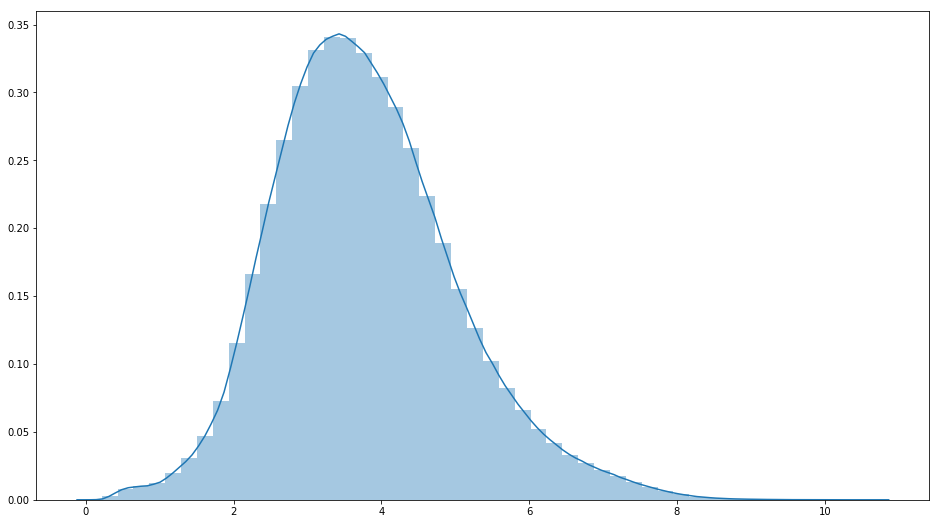

In [29]:
plt.figure(figsize=(16,9))
# plt.hist(n_grams_tfidf_dist_mat.flatten())
sns.distplot(dist_vec)
# sns.kdeplot()

In [ ]:
freq_dists=pd.crosstab(index=np.round_(dist_vec[dist_vec<.6],3), columns="count")

In [ ]:
print(freq_dists.iloc[400:500,:])#.iloc[:50,:])
freq_dists.iloc[400:500,:].plot(kind="bar",figsize=(16,9))##.iloc[200:500,:]
#0.168

In [ ]:
max_eps=.475
min_eps=.45
eps_par=min_eps+((max_eps-min_eps)/2)
print(eps_par)

In [ ]:
db_scan = DBSCAN(eps=eps_par, min_samples=70).fit(spect_emb_3)#spect_emb_tfidf)
spect_db_labels = db_scan.labels_

In [ ]:
pd.crosstab(index=spect_db_labels, columns="count")

In [ ]:
plt.figure(figsize=(10,30))
par_alf=.01#(spect_db_labels>-.5)*.1#0.1
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

plt.subplot(311)
plt.scatter(spect_emb_3[spect_db_labels==-1,0],spect_emb_3[spect_db_labels==-1,1], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==0,0],spect_emb_3[spect_db_labels==0,1], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==1,0],spect_emb_3[spect_db_labels==1,1], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==2,0],spect_emb_3[spect_db_labels==2,1], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==3,0],spect_emb_3[spect_db_labels==3,1], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==4,0],spect_emb_3[spect_db_labels==4,1], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)

plt.subplot(312)
plt.scatter(spect_emb_3[spect_db_labels==-1,2],spect_emb_3[spect_db_labels==-1,1], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==0,2],spect_emb_3[spect_db_labels==0,1], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==1,2],spect_emb_3[spect_db_labels==1,1], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==2,2],spect_emb_3[spect_db_labels==2,1], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==3,2],spect_emb_3[spect_db_labels==3,1], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==4,2],spect_emb_3[spect_db_labels==4,1], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)

plt.subplot(313)
plt.scatter(spect_emb_3[spect_db_labels==-1,0],spect_emb_3[spect_db_labels==-1,2], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==0,0],spect_emb_3[spect_db_labels==0,2], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
plt.scatter(spect_emb_3[spect_db_labels==1,0],spect_emb_3[spect_db_labels==1,2], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==2,0],spect_emb_3[spect_db_labels==2,2], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==3,0],spect_emb_3[spect_db_labels==3,2], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==4,0],spect_emb_3[spect_db_labels==4,2], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)


# Animate - Export 3d clusters

In [ ]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for lb in np.unique(label):
    ax.scatter(spect_emb_3[label == lb, 0], 
               spect_emb_3[label == lb, 1], 
               spect_emb_3[label == lb, 2],
               color=plt.cm.Set1(float(lb) / np.max(label + 1)),
               s=20, edgecolor=None, alpha=.15)
plt.title('Ward Clustering Spectral embedding With connectivity constraints')
plt.show()
# plt.axis('off') # remove axes for visual appeal

def rotate(angle):
    ax.view_init(azim=angle)

print("Making animation")
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
print("Saving Movie File")
rot_animation.save('cluster_anim_4.mp4', writer=writer)
print("Saving animated GIF File")
rot_animation.save('whljgr_clustering_4.gif', dpi=80, writer='imagemagick')

In [31]:
author_data["cluster"]=label
author_data["embd_x_coord"]=spect_emb_3[:,0]
author_data["embd_y_coord"]=spect_emb_3[:,1]
author_data["embd_z_coord"]=spect_emb_3[:,2]

ValueError: Length of values does not match length of index

In [32]:
author_data.head(30)

gender  age                 topic         sign grupo_edad  Freq
id                                                                      
2059027    male   15               Student          Leo          A     4
3581210    male   33     InvestmentBanking     Aquarius          C    70
3539003  female   14                indUnk        Aries          A    21
4172416  female   25                indUnk    Capricorn          B     2
3668238  female   17               Student       Gemini          A    10
4030905  female   17               Student        Aries          A    25
4198080  female   23                indUnk     Aquarius          B     1
3705830    male   25            Non-Profit       Cancer          B    46
3649763  female   33               Banking     Aquarius          C    13
3389918  female   37                indUnk     Aquarius          C    19
4304458  female   25                indUnk  Sagittarius          B     3
3429420    male   15               Student     Aquarius          A    34
3389671    male   26                indUnk          Leo          B    35
649790   female   24                indUnk      Scorpio          B   191
3022585  female   27             Education     Aquarius          B    85
3808902  female   45                indUnk  Sagittarius          C    14
3176655    male   24           Engineering        Libra          B   119
3667495    male   15               Science        Libra          A    29
3486574  female   15               Student       Gemini          A     5
4275555  female   34                indUnk      Scorpio          C     6
1240631    male   41  Communications-Media        Libra          C    14
3711014    male   24      BusinessServices       Cancer          B    19
3168577    male   23                indUnk  Sagittarius          B    49
1550279    male   17               Student  Sagittarius          A    32
1916038  female   14                indUnk       Cancer          A     3
3568056    male   17     Sports-Recreation    Capricorn          A    75
3359005    male   14               Student      Scorpio          A    46
2012853  female   23                indUnk        Libra          B    17
4291530  female   23                indUnk        Virgo          B     2
4313749  female   25                indUnk       Taurus          B     6

In [ ]:
author_data.to_csv("author_data_clusters_2.csv")

# Explore Clusters

In [30]:
pd.crosstab(index=author_data.topic, columns=author_data.cluster)

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [ ]:
pd.crosstab(index=author_data.grupo_edad, columns=author_data.cluster)

In [ ]:
pd.crosstab(index=[author_data.topic,author_data.grupo_edad], columns=author_data.cluster)

In [ ]:
centroides_median=np.array([[np.median(author_data.loc[author_data.cluster==clst,"embd_x_coord"]),
                             np.median(author_data.loc[author_data.cluster==clst,"embd_y_coord"]),
                             np.median(author_data.loc[author_data.cluster==clst,"embd_z_coord"])]
 for clst in list(set(author_data.cluster))])

In [ ]:
enumerate(list(set(author_data.cluster)))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=spect_emb_3[:,0],
           ys=spect_emb_3[:,1],
           zs=spect_emb_3[:,2],
           c=label, 
           alpha=0.05,
           cmap=plt.cm.Set1)

# ax.scatter(xs=centroides_median[:,0],
#            ys=centroides_median[:,1],
#            zs=centroides_median[:,2], 
#            s=500)

for i, txt in enumerate(list(set(author_data.cluster))):
    ax.text(centroides_median[i,0],
            centroides_median[i,1],
            centroides_median[i,2],
            '%s' % (str(txt)), size=20, zorder=1, color='k')

plt.title("Ward's hierarchical clustering from spectral embedding" )

# Wordclouds

In [33]:
# tfidf_data=pd.read_csv("tfidf_data_auth_416.csv",header=0,index_col="id")#("usr_txt_ftr_3.csv",header=0,index_col="id")
# del tfidf_data['Unnamed: 0']
tfidf_data.sample(20)
tfidf_data.shape

(18981, 500)

In [34]:
author_tfidf=tfidf_data_sample#pd.read_csv("usr_txt_ftr_3.csv",header=0,index_col="id")
# del author_tfidf['don']
# del author_tfidf['just']
print(author_tfidf.shape)
author_tfidf.sample(20)

(5694, 500)


though  school  always  ever  better  myself  let  year  another  \
id                                                                          
4208719      11       7       0     2       6       2    1     2        4   
3706109       2       0       2     1       0       1    2     1        1   
2104957       0       0       3     0       3       3    4     1        3   
4164149       3       9       0     0       2       0    0     0        2   
3092694       1       0       2     1       5       3    0     0        3   
3971424       6       6       4     4       1       2    0     1        1   
4177364       0       1       1     0       0       0    0     0        0   
3605427      18       1       8     5       2       7    4     1        1   
3899997      11      50      10    10      15      24    7    38       20   
4125928       1       0       0     0       0       0    1     0        0   
3483108      14       0       3     6      11      15    9     8        4   
3989287       1       0       0     1       1       0    0     0        0   
2787343       0       1       1     0       3       0    1     0        0   
3934445       0       0       0     2       0       0    2     0        0   
4186203       1       0       2     1       0       4    0     0        5   
3662075      30      47      15    41      25      40   18    25       36   
4287988      12       6       8     7       5      13    4    14        6   
3939175       1       0       2     0       0       0    0     1        0   
3373089       2       2       1     0       1       3    0     0        0   
3648082      29      34      22    26      30      32   29    67       47   

         many   ...    president  english  cute  longer  internet  dead  rock  \
id              ...                                                             
4208719     0   ...            0        0     0       1         0     1     1   
3706109     0   ...            0        0     0       0         0     0     0   
2104957     2   ...            0        0     0       2         0     1     0   
4164149     3   ...            0        3     2       2         0     0     0   
3092694     2   ...            0        0     0       0         1     1     0   
3971424     1   ...            0        0     0       0         1     0     0   
4177364     3   ...            0        0     0       0         0     0     0   
3605427     2   ...            1        0     0       0         0     1    10   
3899997     4   ...            0       21     3       0         8     5     2   
4125928     0   ...            0        0     0       1         0     0     0   
3483108     6   ...            0        0     0       2         0     1     1   
3989287     0   ...            0        0     0       0         0     0     0   
2787343     2   ...            0        0     0       0         2     0     0   
3934445     2   ...            0        0     0       1         0     0     0   
4186203     0   ...            0        0     2       0         1     4     0   
3662075    44   ...            4       67     7       1         6     6     0   
4287988     8   ...            2        0     6       0         0     2     8   
3939175     1   ...            0        0     0       0         0     0     0   
3373089     0   ...            0        0     0       0         0     0     0   
3648082    26   ...            3        3    18       4         4    12     6   

         special  road  forget  
id                              
4208719        0     1       0  
3706109        0     0       0  
2104957        0     0       0  
4164149        1     0       0  
3092694        0     0       0  
3971424        1     0       1  
4177364        0     0       0  
3605427        1     3       3  
3899997        3     0       1  
4125928        0     0       0  
3483108        0     0       0  
3989287        0     0       0  
2787343        0     0       0  
3934445        0     6       0  
418

In [36]:
# author_data=pd.read_csv("author_data_clusters_2.csv",header=0,index_col="id")
# print(author_data.shape)
# author_data.sample(20)

In [43]:
clrs_wrdcld=matplotlib.colors.LinearSegmentedColormap.from_list("", [#'#a50026',
                                                                     '#d73027',
                                                                     '#f46d43',
                                                                     '#fdae61',
#                                                                      '#fee090',
#                                                                      '#ffffbf',
#                                                                      '#e0f3f8',
#                                                                      '#abd9e9',
                                                                     '#74add1',
                                                                     '#4575b4',
                                                                     '#313695'])

In [41]:
pic_wide=900
def wrd_cld_dic_clust(clust_labels,clust_id,top_n=300):
    txt_freqs= author_tfidf[clust_labels==clust_id].sum(axis=0)
    indices = np.argsort(txt_freqs)[::-1]
    features =list(author_tfidf.columns)
    top_features = [[features[i],txt_freqs[i]] for i in indices[:top_n]]
    fr_dic={ str(features[i]).upper():txt_freqs[i] for i in indices[:top_n]}
    wc = WordCloud(width=pic_wide,  height=int(pic_wide*(9/21)), 
               background_color=None, mode="RGBA",min_font_size=8,
               colormap=clrs_wrdcld)#Dark2_r)#Paired_r)#tab10_r)#Set1_r) #
    wc.generate_from_frequencies(fr_dic)
    return wc

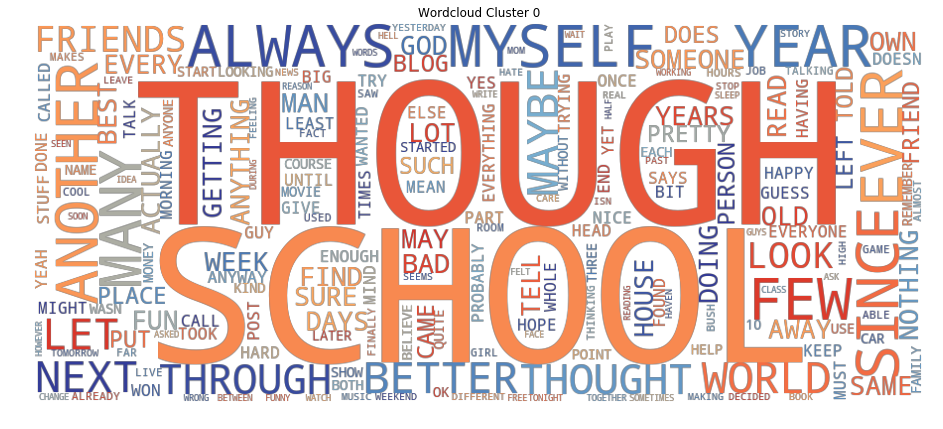

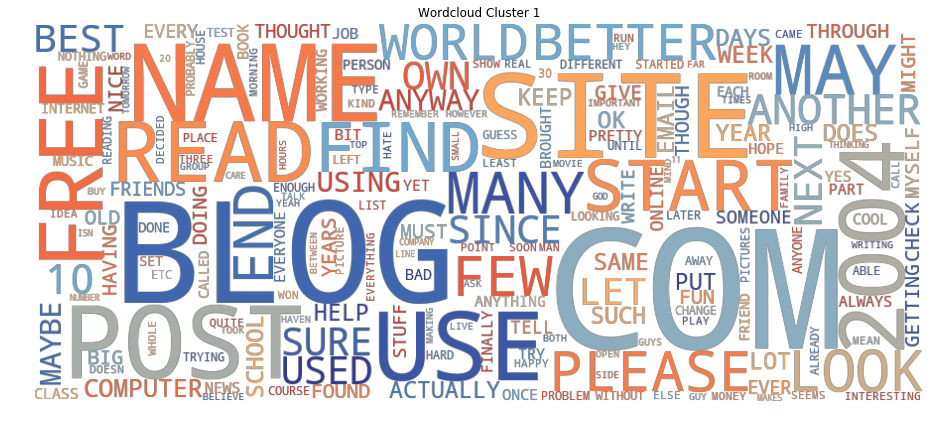

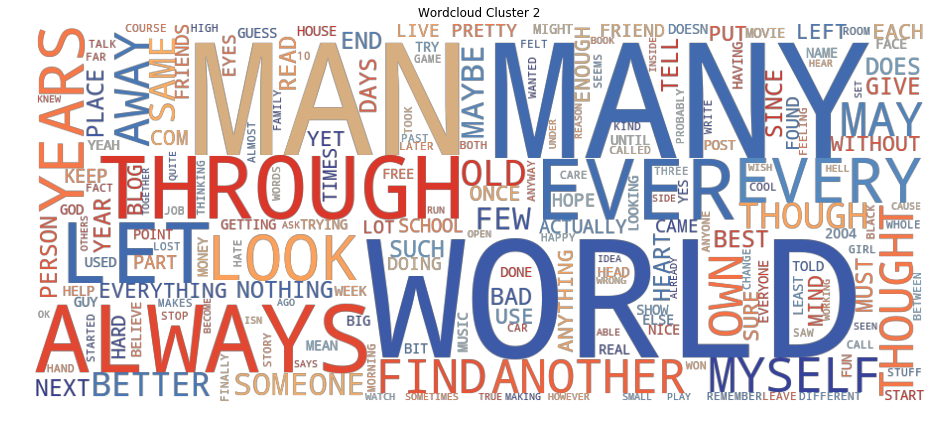

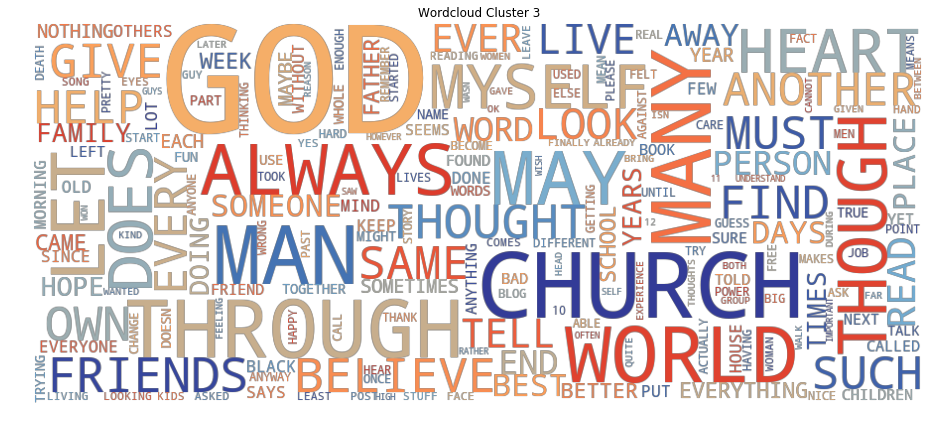

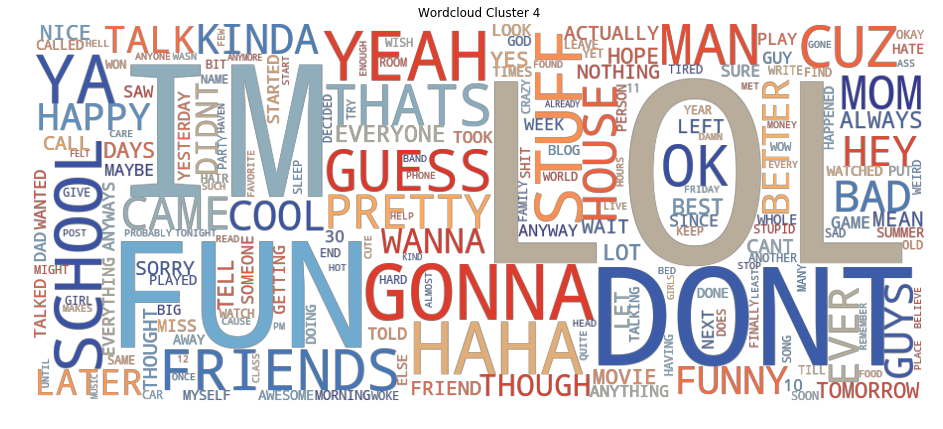

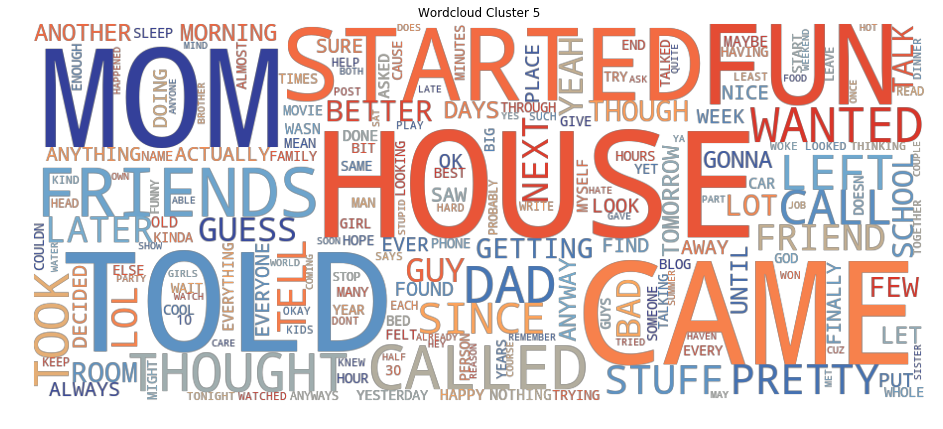

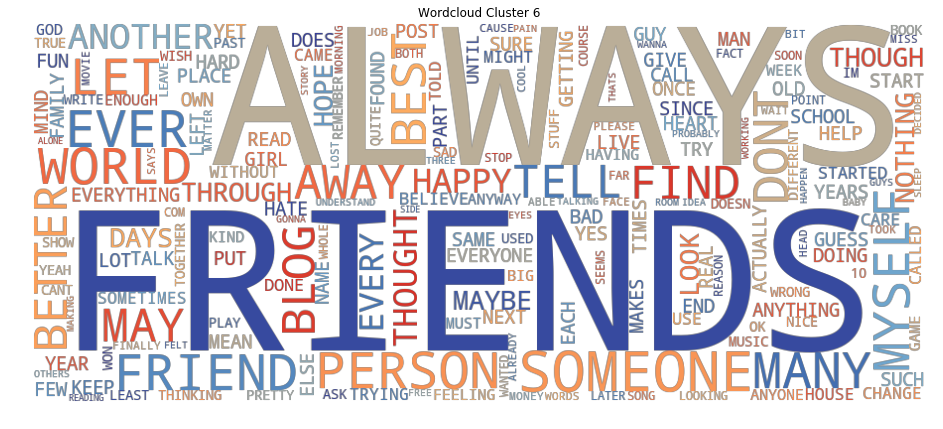

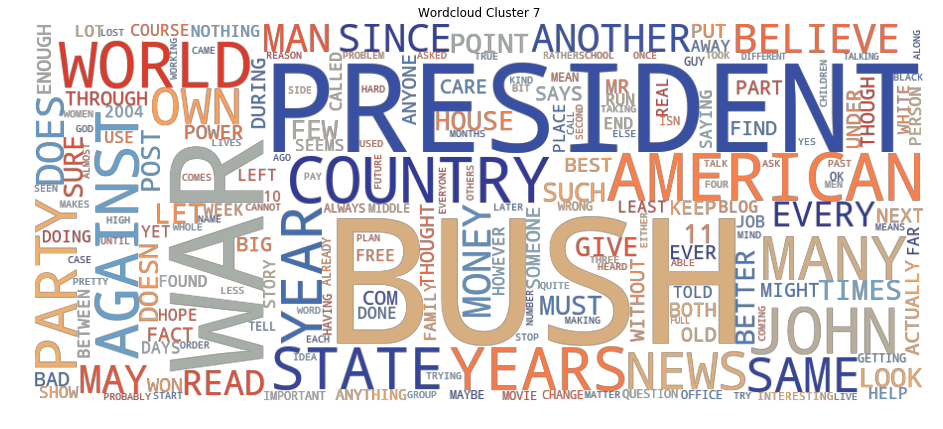

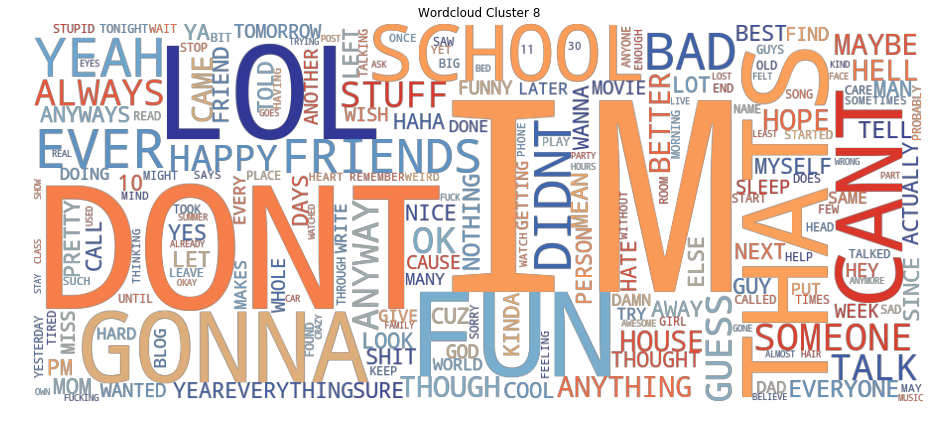

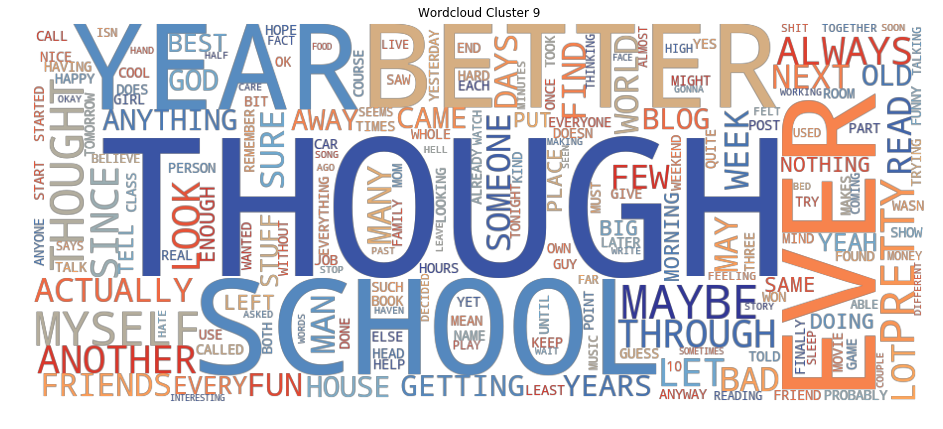

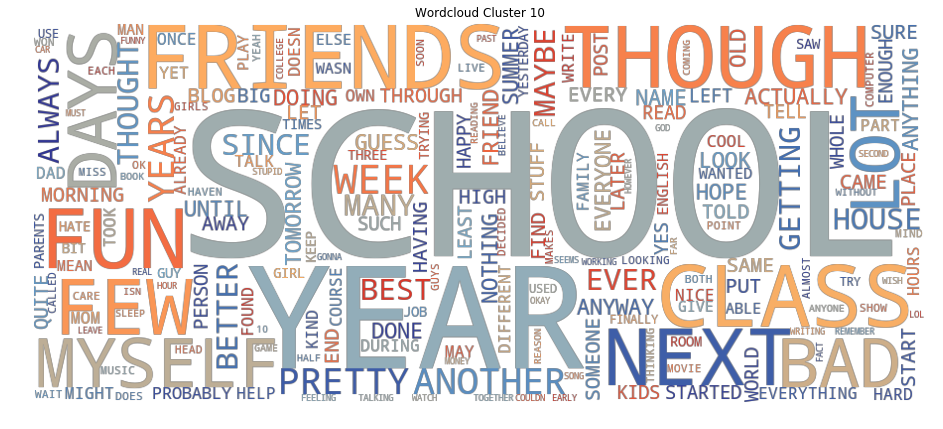

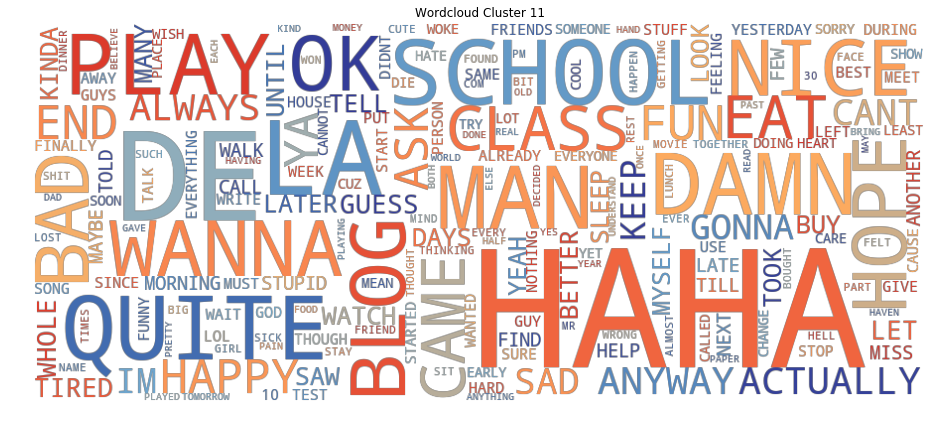

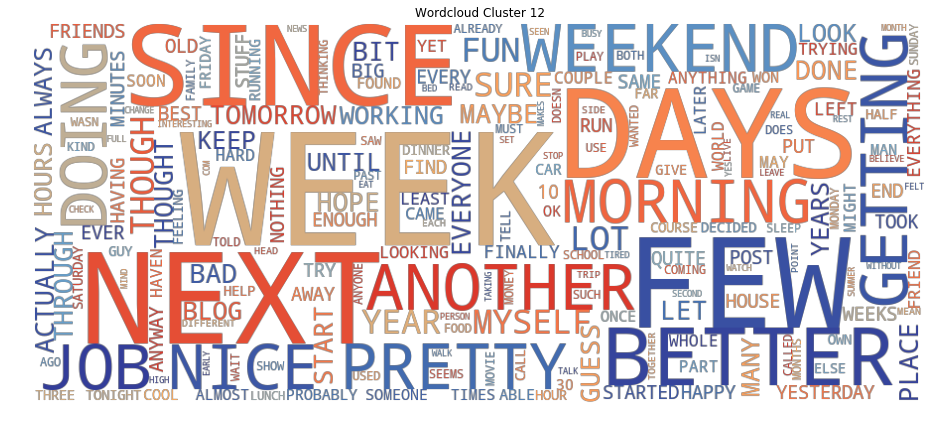

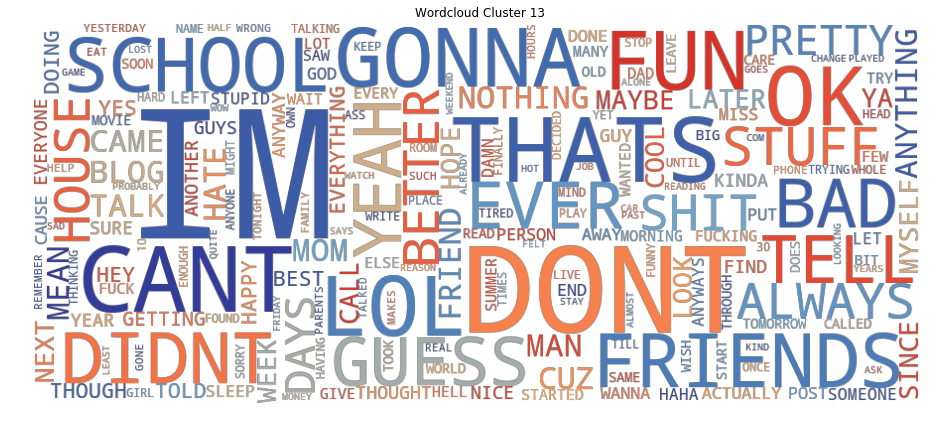

In [44]:
for i, txt in enumerate(list(set(label))):
    plt.figure(figsize=(16,9))
    plt.imshow(wrd_cld_dic_clust(label,i,200), interpolation='bilinear')
    plt.axis("off")
    plt.title("Wordcloud Cluster "+ str(i))


## Significative frequent word by cluster

In [ ]:
freq_words_clust=((author_tfidf>0)*1).groupby(author_data.cluster).sum().T